# Método de los Elementos Finitos con Python

*Esta notebook fue creada originalmente como un blog post por [Raúl E. López Briega](https://relopezbriega.com.ar/) en [Matemáticas, análisis de datos y python](https://relopezbriega.github.io). El contenido esta bajo la licencia BSD.*

<img alt="Método de los Elementos Finitos con python" title="Método de los Elementos Finitos con python" src="https://relopezbriega.github.io/images/FEM.png
" >

Saludos!

*Este post fue escrito utilizando Jupyter notebook. Pueden descargar este [notebook](https://github.com/relopezbriega/relopezbriega.github.io/blob/master/downloads/pyFEM.ipynb) o ver su version estática en [nbviewer](https://nbviewer.ipython.org/github/relopezbriega/relopezbriega.github.io/blob/master/downloads/pyFEM.ipynb).*

## Introducción

Muchos fenómenos físicos en ciencia e [ingeniería](https://es.wikipedia.org/wiki/Ingenier%C3%ADa) pueden ser descritos en términos de [ecuaciones en derivadas parciales](https://relopezbriega.github.io/blog/2016/01/27/ecuaciones-en-derivadas-parciales-con-python/), y como describí en mi [artículo](https://relopezbriega.github.io/blog/2016/01/27/ecuaciones-en-derivadas-parciales-con-python/) dedicado a este tipo de ecuaciones, resolverlas a través del método analítico clásico puede ser algo bastante complicado y muchas veces imposible de realizar. El [Método de los Elementos Finitos](https://es.wikipedia.org/wiki/M%C3%A9todo_de_los_elementos_finitos) o [MEF](https://es.wikipedia.org/wiki/M%C3%A9todo_de_los_elementos_finitos), para abreviar; es un enfoque numérico por el cual las [ecuaciones en derivadas parciales](https://relopezbriega.github.io/blog/2016/01/27/ecuaciones-en-derivadas-parciales-con-python/) pueden ser resueltas en forma aproximada. El [MEF](https://es.wikipedia.org/wiki/M%C3%A9todo_de_los_elementos_finitos) está pensado para ser con el enorme poder de cálculo de las computadoras modernas y permite resolver [ecuaciones diferenciales](https://relopezbriega.github.io//blog/2016/01/10/ecuaciones-diferenciales-con-python/) asociadas a un problema físico sobre geometrías complicadas. Este método se usa en el diseño y mejora de productos y aplicaciones industriales, así como en la simulación de sistemas físicos y biológicos complejos. La variedad de problemas a los que puede aplicarse ha crecido enormemente, utilizándose principalmente en áreas como [mecánica estructural](https://en.wikipedia.org/wiki/Structural_mechanics), [mecánica de fluidos](https://es.wikipedia.org/wiki/Mec%C3%A1nica_de_fluidos), problemas de [tensión mecánica](https://es.wikipedia.org/wiki/Tensi%C3%B3n_mec%C3%A1nica) y problemas de [transferencia de calor](https://es.wikipedia.org/wiki/Transferencia_de_calor).

## ¿En qué consiste el Método de los Elementos Finitos?

La idea general detrás del [Método de los Elementos Finitos](https://es.wikipedia.org/wiki/M%C3%A9todo_de_los_elementos_finitos) es la división de un *continuo* en un
conjunto de pequeños *elementos* interconectados por una serie de puntos llamados *nodos*. 
Las ecuaciones que rigen el comportamiento del continuo regirán también el del elemento.
De esta forma se consigue pasar de un sistema continuo (infinitos grados de libertad), que
es regido por una [ecuación diferencial](https://relopezbriega.github.io//blog/2016/01/10/ecuaciones-diferenciales-con-python/) o un sistema de [ecuaciones diferenciales](https://relopezbriega.github.io//blog/2016/01/10/ecuaciones-diferenciales-con-python/), a un
sistema con un número de grados de libertad finito cuyo comportamiento se modela por un
sistema de ecuaciones, lineales o no. 

<img alt="Método de los Elementos Finitos con python" title="Método de los Elementos Finitos con python" src="https://relopezbriega.github.io/images/FEM.png
" >

Por ejemplo, en la imagen que vemos arriba, podemos ver que en primer lugar tenemos una placa con un hueco en el centro, supongamos que queremos determinar su distribución de temperatura. Para realizar esto, deberíamos resolver la [ecuación del calor](https://es.wikipedia.org/wiki/Ecuaci%C3%B3n_del_calor) para cada punto en la placa. El enfoque que utiliza el [Método de los Elementos Finitos](https://es.wikipedia.org/wiki/M%C3%A9todo_de_los_elementos_finitos) es el de dividir al objeto en *elementos finitos* conectados entre sí por *nodos*; como lo muestran la tercera y cuarta imagen de la cabecera del artículo. Este nuevo objeto, constituido por los *elementos finitos* (los triángulos de la segunda imagen) se llama *[malla](https://es.wikipedia.org/wiki/Malla_poligonal)* y es una representación aproximada del objeto original. De esta forma, pasamos de un problema continuo (infinito puntos) a un problema discreto (número de *nodos* de los *elementos finitos*). Para aproximarnos lo más posible al objeto original, generalmente se necesitan un número elevado de *nodos*, por lo que las computadoras son esenciales para resolver el problema.

NameError: name 'interactive' is not defined

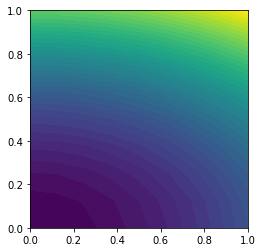

In [4]:
from fenics import *
import numpy as np

T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, bc)

    # Plot solution
    plot(u)

    # Compute error at vertices
    u_e = interpolate(u_D, V)
    error = np.abs(np.array(u_e.vector()) - np.array(u.vector()).max())
    #print('t = %.2f: error = %.3g' % (t, error))

    # Update previous solution
    u_n.assign(u)

# Hold plot
interactive()